# Импорт библиотек и чтение датасетов

In [1]:
# модуль для работы с датафреймами
import pandas as pd

# модуль для работы с массивами
import numpy as np

# модуль для визуализации результатов
import matplotlib.pyplot as plt

# модуль с моделью CatBoost
from catboost import CatBoostRegressor

# модуль с метриками
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузка данных

In [2]:
# Загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

# логирование
print(f'Размер тренировочной выборки: {train_df.shape}')
print(f'Размер тестовой выборки: {test_df.shape}')


FileNotFoundError: [Errno 2] No such file or directory: 'data/excel/train.xlsx'

Подготовка данных

Приводим колонку с датой в формат `datetime`

In [ ]:
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)

Для более удобной работы с признаками, переименуем колонку с ценой

In [ ]:
# Переименовываем колонку с ценой
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

In [ ]:
# Объединение данных
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).reset_index(drop=True)
# логирование
print(f'Размер объединенного датасета: {combined_df.shape}')

Размер объединенного датасета: (428, 2)


In [ ]:
combined_df = combined_df.set_index('dt', drop=True)

In [ ]:
X = combined_df.drop(columns=['Price']).iloc[:-1, :]
y = combined_df['Price'].values[1:]
X['Price_source'] = combined_df['Price'].values[:-1]
y = y[1:]
X = X.iloc[1:, :]

Разбиение данных на тренировочную и тестовую выборки

In [ ]:
# Разделение данных
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
# Логарифмирование целевой переменной
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

In [ ]:
# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)

Создаем объект с моделью

In [ ]:
# Параметры модели
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=3,
    loss_function='MAE',
    early_stopping_rounds=100,
    has_time=True,                    # Учитываем временную зависимость
    l2_leaf_reg=10,                   # Регуляризация
)
# Обучение модели
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

0:	learn: 0.1812358	test: 0.4609899	best: 0.4609899 (0)	total: 1.01ms	remaining: 2.02s
1:	learn: 0.1773057	test: 0.4554489	best: 0.4554489 (1)	total: 1.94ms	remaining: 1.94s
2:	learn: 0.1732011	test: 0.4510916	best: 0.4510916 (2)	total: 2.91ms	remaining: 1.94s
3:	learn: 0.1689144	test: 0.4401581	best: 0.4401581 (3)	total: 3.69ms	remaining: 1.84s
4:	learn: 0.1653040	test: 0.4365098	best: 0.4365098 (4)	total: 4.56ms	remaining: 1.82s
5:	learn: 0.1612908	test: 0.4231830	best: 0.4231830 (5)	total: 5.39ms	remaining: 1.79s
6:	learn: 0.1578686	test: 0.4192598	best: 0.4192598 (6)	total: 6.19ms	remaining: 1.76s
7:	learn: 0.1543595	test: 0.4154544	best: 0.4154544 (7)	total: 6.89ms	remaining: 1.72s
8:	learn: 0.1513062	test: 0.4117631	best: 0.4117631 (8)	total: 7.81ms	remaining: 1.73s
9:	learn: 0.1482129	test: 0.4010427	best: 0.4010427 (9)	total: 8.88ms	remaining: 1.77s
10:	learn: 0.1439263	test: 0.3886867	best: 0.3886867 (10)	total: 10.2ms	remaining: 1.85s
11:	learn: 0.1407997	test: 0.3854292	best

In [ ]:

mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

0:	learn: 0.1387950	total: 913us	remaining: 1.83s
1:	learn: 0.1353956	total: 1.94ms	remaining: 1.94s
2:	learn: 0.1319475	total: 2.88ms	remaining: 1.92s
3:	learn: 0.1280097	total: 4.53ms	remaining: 2.26s
4:	learn: 0.1248035	total: 5.34ms	remaining: 2.13s
5:	learn: 0.1217421	total: 6.28ms	remaining: 2.09s
6:	learn: 0.1188515	total: 7.31ms	remaining: 2.08s
7:	learn: 0.1162308	total: 8.07ms	remaining: 2.01s
8:	learn: 0.1133077	total: 8.7ms	remaining: 1.93s
9:	learn: 0.1108952	total: 9.71ms	remaining: 1.93s
10:	learn: 0.1085322	total: 10.5ms	remaining: 1.9s
11:	learn: 0.1056965	total: 11ms	remaining: 1.83s
12:	learn: 0.1034184	total: 11.7ms	remaining: 1.79s
13:	learn: 0.1011094	total: 12.2ms	remaining: 1.74s
14:	learn: 0.0989495	total: 13ms	remaining: 1.72s
15:	learn: 0.0967597	total: 13.7ms	remaining: 1.7s
16:	learn: 0.0946601	total: 19ms	remaining: 2.22s
17:	learn: 0.0927218	total: 20.1ms	remaining: 2.21s
18:	learn: 0.0907751	total: 21.1ms	remaining: 2.19s
19:	learn: 0.0887485	total: 23.9

In [ ]:
# Предсказание
preds = np.expm1(model.predict(X_test))

# Метрики
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.7063
MAE: 5170.1104
MSE: 38483443.2303
RMSE: 6203.5025
Средний MAE на кросс-валидации: 0.0779
Средний R² на кросс-валидации: 0.5083


Проверка работы модели на графике

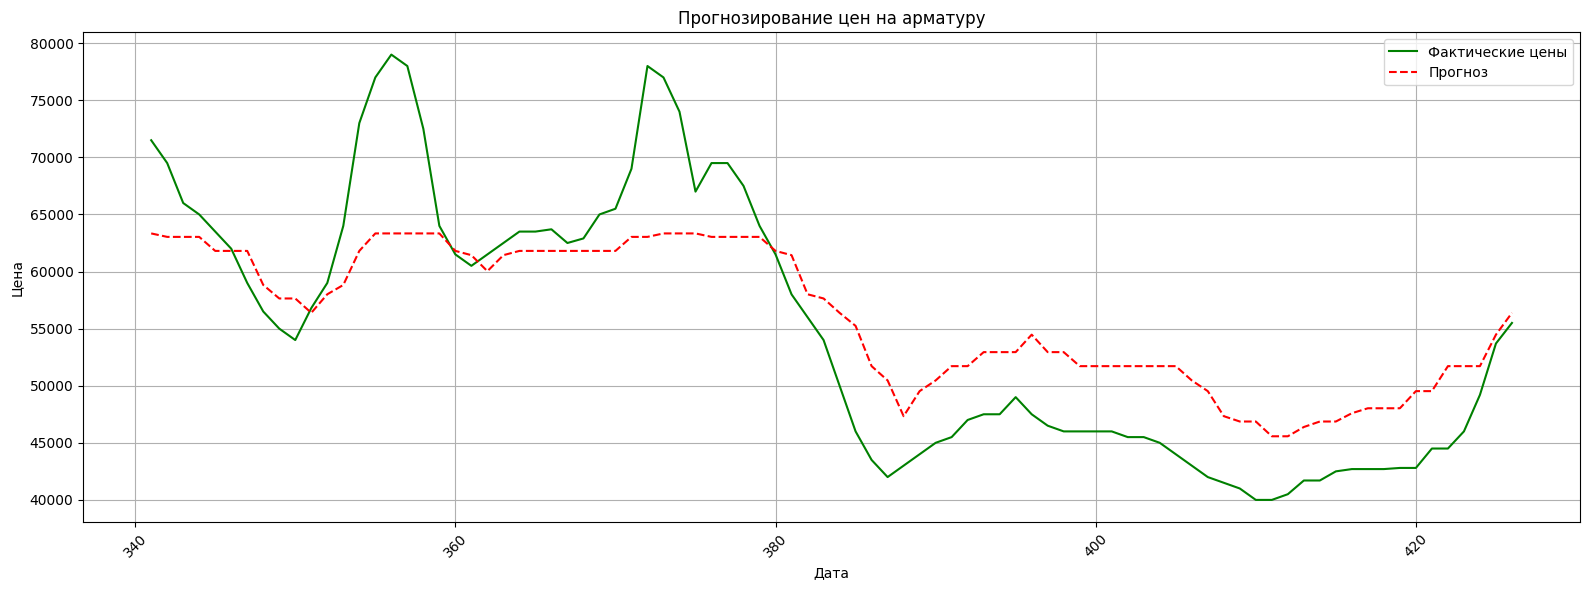

In [ ]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохранение модели
model.save_model("catboost_model.cbm")

In [ ]:
# from sklearn.neighbors import KNeighborsRegressor


# # Создание скользящего окна
# window_size = 3
# X = np.array([combined_df[i:i+window_size] for i in range(len(combined_df) - window_size)])
# y = np.array([combined_df[i+window_size] for i in range(len(combined_df) - window_size)])

# # Обучение модели k-NN
# knn = KNeighborsRegressor(n_neighbors=2)
# knn.fit(X, y)

# # Прогноз для нового окна
# new_window = np.array([[7, 8, 9]])
# prediction = knn.predict(new_window)
# print(f"Прогноз: {prediction[0]}")

In [ ]:
combined_df

,Price
dt,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
...,...
2023-02-13,44500
2023-02-20,46000
2023-02-27,49200


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Параметры модели XGBoost
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=3,
    objective='reg:squarederror',
    reg_lambda=10,  # Регуляризация L2
    # early_stopping_rounds=100,
    eval_metric='mae',
)

# Обучение модели
model.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)

# Оценка модели с помощью кросс-валидации
mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

# Предсказание
preds = np.expm1(model.predict(X_test))

# Метрики
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.9130
MAE: 2663.5612
MSE: 11396711.9874
RMSE: 3375.9017
Средний MAE на кросс-валидации: 0.0560
Средний R² на кросс-валидации: 0.7411


In [ ]:
X_test

,dt,Price_source
341,2021-07-19,72500
342,2021-07-26,71500
343,2021-08-02,69500
344,2021-08-09,66000
345,2021-08-16,65000
...,...,...
422,2023-02-06,44500
423,2023-02-13,44500
424,2023-02-20,46000
425,2023-02-27,49200


In [ ]:
y_test

array([71500, 69500, 66000, 65000, 63500, 62000, 59000, 56500, 55000,
       54000, 56800, 59000, 64000, 73000, 77000, 79000, 78000, 72500,
       64000, 61500, 60500, 61500, 62500, 63500, 63500, 63700, 62500,
       62900, 65000, 65500, 69000, 78000, 77000, 74000, 67000, 69500,
       69500, 67500, 64000, 61500, 58000, 56000, 54000, 50000, 46000,
       43500, 42000, 43000, 44000, 45000, 45500, 47000, 47500, 47500,
       49000, 47500, 46500, 46000, 46000, 46000, 46000, 45500, 45500,
       45000, 44000, 43000, 42000, 41500, 41000, 40000, 40000, 40500,
       41700, 41700, 42500, 42700, 42700, 42700, 42800, 42800, 44500,
       44500, 46000, 49200, 53700, 55500], dtype=int64)